# Nhóm 24
# Danh sách thành viên:

- Trần Xuân Quý - 18120231
- Trương Minh Tài - 18120544

# 1. Import các thư viện cần thiết

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time, json, csv, re, os

In [1]:
%matplotlib inline
import numpy as np
import math
import seaborn as sns
import pandas as pd
from datetime import date
import datetime

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer, OneHotEncoder, StandardScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.neural_network import MLPClassifier

from sklearn.compose import make_column_transformer
from sklearn.decomposition import TruncatedSVD

from sklearn import set_config
set_config(display='diagram')

In [24]:
from matplotlib import pyplot as plt

---

# 2. Thu thập dữ liệu

[Kickstarter](https://www.kickstarter.com) là trang web cho phép người dùng gọi vốn từ cộng đồng để phát triển một sản phẩm nào đó thuộc lĩnh vực như là: nghệ thuật, truyện tranh, chế tác, phim ảnh, thực phẩm, báo chí, âm nhạc, game, thiết kế, ...

Trong đồ án, nhóm chúng em sẽ thu thập môt số dữ liệu về các dự án hiện có trên nền tảng kickstarter. Theo như file [robots.txt](https://www.kickstarter.com/robots.txt) của kickstarter thì trang không cho phép thu thập thông tin về người hỗ trợ, số tiền đã được góp vốn, widget trong từng trang dự án và trang hồ sơ người dùng, còn lại thì không bị cấm. Nhóm thực hiện thu thập trên trang [discover](https://www.kickstarter.com/discover?ref=nav) nên không vi phạm yêu cầu của kickstarter.

Ở đây nhóm sử dụng thư viện Selenium vì cần phải thực hiện một số thao tác click chuột và cuộn trang thì kickstarter mới tải thêm dữ liệu.

- Sử dụng thư viện Selenium truy cập trang [discover](https://www.kickstarter.com/discover?ref=nav) của kickstarter và thu thập thông tin của tất cả project hiện có.
- Dữ liệu của các dự án được thu thập bao gồm: id, tên, lời giới thiệu, số tiền mục tiêu, số tiền đã kêu gọi, quốc gia, hạn chót, ngày tạo, ngày khởi động, số người tham gia hỗ trợ, tỉ giá ngoại tê, thể loại, thể loại chính và kết quả gọi vốn của dự án.
- Dữ liệu thu thập được lưu vào file projects_raw.tsv

In [ ]:
# tạo file tsv lưu dữ liệu
projects_data = open('projects_raw.tsv', 'w', newline='', encoding='utf-8')

In [ ]:
# tạo danh sách các cột
columns = ['id','name','blurb','goal','pledged','country','deadline','created_at','launched_at',
           'backers_count','fx_rate','category','main_category','state']

# tạo danh sách các cột có thể thu thập trực tiếp
cols_collect_data = columns.copy()
cols_collect_data.remove('category')
cols_collect_data.remove('main_category')

In [ ]:
# tạo đối tượng ghi file và ghi vào tên cột
writer = csv.DictWriter(projects_data, fieldnames=columns,delimiter='\t')
writer.writeheader()

In [ ]:
# tạo đối tượng webdriver và truy cập trang kickstarter.com mục discover
# browser = webdriver.Chrome(executable_path = './browser_drivers/chromedriver.exe')
browser = webdriver.Edge(executable_path = '../browser_drivers/msedgedriver.exe')
browser.get('https://www.kickstarter.com/discover?ref=nav')

In [ ]:
# parse trang vừa tải
html_tree = BeautifulSoup(browser.page_source, 'html.parser')

In [ ]:
# tìm đường dẫn tới những thể loại, lĩnh vực
categories_ls = []
cat_filter = html_tree.find('select', {'name':'category_id'})

In [ ]:
# tìm tag option và có thuộc tính data-urls
# kiểm tra tag option có thuộc tính data-parent-id hay không
# nếu có thì thêm vào danh sách đường dẫn
option = cat_filter.find('option', {'data-urls':True})
while True:
    main_cat = False

    try:
        option['data-parent-id']
    except:
        main_cat = True

    if not main_cat:
        categories_ls.append(re.search('"(http:.+)"', option['data-urls']).group(1))

    option = option.next_sibling
    if option == None:
        break

In [ ]:
# tạo từ điển lưu dữ liệu thu thập được
data_collect = dict.fromkeys(cols_collect_data)

# truy cập trang của từng thể loại chính và thu thập dữ liệu
for category_link in categories_ls:
    time.sleep(5) # đợi 1 khoảng thời gian trước khi tải trang mới

    # tải trang và tìm nút 'load more'
    browser.get(category_link)
    browser.find_element_by_class_name('load_more').click()

    # cuộn tới cuối trang để tải thêm project
    last_height = browser.execute_script("return document.body.scrollHeight")
    while True:
        browser.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        time.sleep(2)
        new_height = browser.execute_script("return document.body.scrollHeight")

        if new_height == last_height:
            break

        last_height = new_height

    # sử dụng BeautifulSoup để parse trang web
    html_tree = BeautifulSoup(browser.page_source, 'html.parser')

    # tìm tất cả các tag chứa thông tin về các project
    data_project = html_tree.find_all('div', {'data-project': True})

    # với mỗi project tìm thuộc tính data-project và thu thập dữ liệu
    for project in project_cards:
        data = json.loads(project['data-project'])
        
        # thu thập dữ liệu có thể thu thập trực tiếp
        for attr in cols_collect_data:
            data_collect[attr] = data[attr]

        data_collect['category'] = data['category']['name']
        data_collect['main_category'] = data['category']['parent_name']

        # ghi dữ liệu thu thập dược vào file
        writer.writerow(data_collect)

    # lưu dữ liệu thu thập được
    projects_data.flush()
    os.fsync(projects_data.fileno())

    project_cards.clear()

In [ ]:
# đóng trình duyệt và đóng file
browser.quit()
projects_data.close()

---

# 3. Khám phá dữ liệu

In [2]:
# tạo dataframe
projects_df = pd.read_table('../data/projects_raw.tsv', index_col=0)
projects_df.head()

,name,blurb,goal,pledged,country,deadline,created_at,launched_at,backers_count,fx_rate,category,main_category,state
id,,,,,,,,,,,,,
1295155228,RMo Studio Needs Your Help,Help RMo Studio to buy a new kiln for ceramics...,2500.0,5504.0,GB,1610128800,1606933477,1607299280,152,1.36147,Ceramics,Art,live
39027197,"Animals on Ceramics, Hand Drawn and Handmade, ...",Custom Hand Drawn Animals on Handmade Ceramic ...,120.0,38.0,US,1612504740,1607541996,1609434617,3,1.00000,Ceramics,Art,live
274865,Pots On Wheels,We're creating a mobile outreach gallery of be...,20000.0,25732.0,US,1417496340,1409351310,1415110797,278,1.00000,Ceramics,Art,successful
112491653,Sarah Kersten Handmade Studio,Help build a studio space for Sarah Kersten Ha...,30000.0,35083.0,US,1413573982,1406328440,1410981982,233,1.00000,Ceramics,Art,successful
330304757,The Potter and the RAM,"I make sturdy, high-fired porcelain tableware ...",16000.0,22314.5,US,1383424322,1375916344,1380832322,273,1.00000,Ceramics,Art,successful


## **Dữ liệu có bao nhiêu dòng và cột?**

In [3]:
projects_df.shape

(79922, 13)

## Mỗi dòng có ý nghĩa gì?

Mỗi dòng chứa thông tin về một dự án góp vốn cộng đồng trên kickstarter.

## Dữ liệu có các dòng hay cột bị lặp hay bị thiếu không?

In [4]:
projects_df.duplicated().sum()

3

In [5]:
projects_df.index.duplicated().sum()

3

In [59]:
projects_df.nunique()

name             77926
blurb            77541
goal              3248
pledged          30104
country             25
deadline         75020
created_at       78017
launched_at      78012
backers_count     2902
fx_rate             29
category           139
main_category       15
state                3
dtype: int64

In [6]:
projects_df.isna().describe()

,name,blurb,goal,pledged,country,deadline,created_at,launched_at,backers_count,fx_rate,category,main_category,state
count,79922,79922,79922,79922,79922,79922,79922,79922,79922,79922,79922,79922,79922
unique,1,2,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,79922,79919,79922,79922,79922,79922,79922,79922,79922,79922,79922,79922,79922


In [7]:
projects_df.isna().sum()

name             0
blurb            3
goal             0
pledged          0
country          0
deadline         0
created_at       0
launched_at      0
backers_count    0
fx_rate          0
category         0
main_category    0
state            0
dtype: int64

Như vậy là có 3 dòng bị trùng và có 3 dòng bị thiếu dữ liệu ở cột blurb trong tập dữ liệu. Do số dòng bị trùng và thiếu ít nên để đơn giản nhóm thực hiện xóa các dòng trên.

In [3]:
projects_df.drop_duplicates(inplace=True)
projects_df.shape

(79919, 13)

In [4]:
projects_df.dropna(inplace=True)
projects_df.shape

(79916, 13)

## Ý nghĩa của mỗi cột

Cột | Ý nghĩa
--- | -------
id | Mã định danh cho từng dự án.
name | Tên của dự án.
blurb | Lời giới thiệu ngắn gọn về dự án.
goal | Số tiền dự án yêu cầu.
pledged | Số tiền đã kêu gọi thành công.
country | Quốc gia của người/nhóm chủ dự án.
deadline | Hạn chót kêu gọi góp vốn.
create_at | Ngày tạo dự án.
launched_at | Ngày bắt đầu kêu gọi góp vốn.
backers_count | Số người đã góp vốn cho dự án.
fx_rate | Tỷ giá các đơn vị tiền tệ so với đơn vị tiền tệ được chọn
category | Thể loại của dự án.
main_category | Thể loại chính của dự án.
state | Kết quả gọi vốn của dự án.

## Mỗi cột hiện đang có kiểu dữ liệu gì?

In [10]:
projects_df.dtypes

name              object
blurb             object
goal             float64
pledged          float64
country           object
deadline           int64
created_at         int64
launched_at        int64
backers_count      int64
fx_rate          float64
category          object
main_category     object
state             object
dtype: object

## Tỷ lệ các giá trị của cột kết quả như thế nào?

In [11]:
projects_df['state'].value_counts(normalize=True) * 100

successful    59.521247
failed        34.112068
canceled       4.015466
live           2.351219
Name: state, dtype: float64

**Trong đó:**

Trạng thái | Ý nghĩa
---------- | -------
successful | Dự án đã gọi vốn thành công
failed | Dự án gọi vốn thất bại
canceled | Dự án bị hủy
live | Dự án đang trong thời gian gọi vốn

Trong tập dữ liệu có một số dự án đang trong thời gian gọi vốn - có trạng thái 'live', vì vậy chưa có kết quả cuối cùng. Những dự án như dạng này không hữu ích cho quá trình học của mô hình cũng như để kiểm tra độ lỗi khi sử dụng mô hình để dự đoán do chưa có kết quả cuối cùng. Vì vậy nhóm thực hiện tách các dòng dữ liệu chưa có kết quả trước khi thực hiện chia tập huấn luyện, validation và kiểm tra.

In [5]:
live_projects = projects_df[projects_df['state'] == 'live']
projects_df.drop(live_projects.index, inplace=True)
projects_df.shape

(78037, 13)

---

# 4. Đưa ra câu hỏi cần trả lời

Với tập dữ liệu trên thì cột output là cột state - thể hiện kết quả gọi vốn của một dự án. Như vậy câu hỏi mà nhóm đặt ra với tập dữ liệu này là:

*Output - kết quả* - củ một dự án góp vốn cộng đồng có thể được tính từ *input - các thông tin về dự án* - theo công thức nào?

Việc tìm ra câu trả lời cho câu hỏi này có thể giúp cho một người/nhóm người có ý định kêu gọi góp vốn cộng đồng cho một sản phẩm nào đó họ muốn phát triển có thể phần nào đoán được kết quả của việc gọi vốn, qua đó có thể điều chỉnh dự án của mình - nếu cần thiết - để đạt được kết quả gọi vốn tốt nhất.

---

# 5. Tách các tập huấn luyện, validation và kiểm tra

In [6]:
# tạo tập input và output
y_sr = projects_df['state']
X_df = projects_df.drop(columns='state', axis=1)

In [7]:
# Tách tập kiểm tra với tỷ lệ 20% tập dữ liệu ban đầu
final_train_X_df, test_X_df, final_train_y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size=0.2, stratify=y_sr, random_state=42)

In [9]:
# Tách tập validation với tỷ lệ 20% tập dữ liệu sau khi tách tập kiểm tra
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(final_train_X_df, final_train_y_sr, test_size=0.2,
                                                              stratify=final_train_y_sr, random_state=42)

In [10]:
train_X_df.shape

(49943, 12)

In [11]:
train_y_sr.shape

(49943,)

In [12]:
val_X_df.shape

(12486, 12)

In [13]:
val_y_sr.shape

(12486,)

In [14]:
test_X_df.shape

(15608, 12)

In [15]:
test_y_sr.shape

(15608,)

# 6. Khám phá dữ liệu trên tập huấn luyện

Mỗi cột input có kiểu dữ liệu gì?

In [22]:
train_X_df.dtypes

name              object
blurb             object
goal             float64
pledged          float64
country           object
deadline           int64
created_at         int64
launched_at        int64
backers_count      int64
fx_rate          float64
category          object
main_category     object
dtype: object

Có thể thấy các cột "deadline", "created_at" và "launched_at" có ý nghĩa liên quan đến ngày tháng nhưng hiện đang ở dạng timestamp và có kiểu dữ liệu int64

### Tiền xử lý: Thực hiện chuyển đổi các cột nêu trên về kiểu dữ liệu datetime

In [16]:
def colToDatetime(df):
    date_cols = ['deadline', 'created_at', 'launched_at']
    
    new_df = df.copy()
    new_df[date_cols] = new_df[date_cols].applymap(date.fromtimestamp).apply(pd.to_datetime)
    
    return new_df

In [10]:
preprocess_df = colToDatetime(train_X_df)
preprocess_df.head()

,name,blurb,goal,pledged,country,deadline,created_at,launched_at,backers_count,fx_rate,category,main_category
id,,,,,,,,,,,,
179726144,The Avalon Project,A project I started with creating medieval/Tud...,1500.0,13.00,US,2018-03-12,2017-12-11,2018-01-11,2,1.000000,People,Photography
1180107458,Rider of the Black Sun: A Fantasy Gamebook,Support one of the most ambitious gamebooks ev...,6000.0,41228.00,DE,2017-11-06,2017-08-09,2017-10-09,956,1.217137,Tabletop Games,Games
1948156939,The Band Called FUSE goes to South by SouthWes...,Help The Band Called FUSE tour to SXSW to brin...,3686.0,5227.36,US,2012-03-01,2012-02-01,2012-02-01,133,1.000000,Hip-Hop,Music
100441343,World Premiere Recording: Original Piano Works,Piano works by Myron Silberstein; unpublished ...,2250.0,2270.00,US,2019-03-16,2019-01-29,2019-02-14,24,1.000000,Classical Music,Music
1370866183,The Miskatonic Papers,A limited-edition experiential art book inspir...,22000.0,29211.00,US,2019-09-19,2019-06-20,2019-08-20,151,1.000000,Fiction,Publishing


In [11]:
preprocess_df.dtypes

name                     object
blurb                    object
goal                    float64
pledged                 float64
country                  object
deadline         datetime64[ns]
created_at       datetime64[ns]
launched_at      datetime64[ns]
backers_count             int64
fx_rate                 float64
category                 object
main_category            object
dtype: object

### Tiếp tục khám phá dữ liệu

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào

In [12]:
train_X_df.dtypes[train_X_df.dtypes != object]

goal             float64
pledged          float64
deadline           int64
created_at         int64
launched_at        int64
backers_count      int64
fx_rate          float64
dtype: object

In [13]:
num_cols_df = train_X_df.select_dtypes(exclude='object')
def missing_ratio(s):
    return s.isna().mean() * 100
def median(df):
    return df.quantile(0.5)
def lower_quartile(df):
    return df.quantile(0.25)
def upper_quartile(df):
    return df.quantile(0.75)
num_cols_df.agg([missing_ratio, min, lower_quartile, median, upper_quartile, max]).round(1)

,goal,pledged,deadline,created_at,launched_at,backers_count,fx_rate
missing_ratio,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
min,0.0,0.0,1.241334e+09,1.240366e+09,1.240603e+09,0.0,0.0
lower_quartile,2000.0,185.0,1.417292e+09,1.410378e+09,1.414438e+09,5.0,1.0
median,5000.0,2250.0,1.463581e+09,1.456685e+09,1.460749e+09,34.0,1.0
upper_quartile,15000.0,10003.5,1.530034e+09,1.522805e+09,1.527034e+09,115.0,1.0
max,100000000.0,235320528.0,1.613467e+09,1.608782e+09,1.608794e+09,105857.0,1.4


### Với mỗi cột input có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [14]:
pd.set_option('display.max_colwidth', 200)
cat_cols_df = train_X_df.select_dtypes(include='object')
def value_counts(col):
    return dict(col.value_counts())
cat_cols_df.agg([missing_ratio, pd.Series.nunique, value_counts])

,name,blurb,country,category,main_category
missing_ratio,0,0,0,0,0
nunique,49895,49726,24,138,15
value_counts,"{'Full Circle': 4, 'A Midsummer Night's Dream': 4, 'Home': 3, 'Influencias (Canceled)': 3, 'One Day': 3, 'Online Free Sound Effects/store (Canceled)': 2, 'Artist Residency at the Vermont Studio Ce...","{'Mind, Body, Spirit Fitness hands-on seminar for people in high stress jobs, labor intensive jobs, seniors, and students: workout incl.': 8, 'The Decentralized Dance Party was founded on the beli...","{'US': 34524, 'GB': 5809, 'CA': 2274, 'AU': 1184, 'DE': 946, 'FR': 764, 'MX': 678, 'IT': 645, 'ES': 486, 'NL': 461, 'SE': 401, 'HK': 305, 'DK': 215, 'NZ': 202, 'SG': 180, 'IE': 154, 'CH': 153, 'BE...","{'Web': 1985, 'Apps': 964, 'Plays': 951, 'Gadgets': 925, 'Performance Art': 860, 'DIY Electronics': 834, 'Classical Music': 790, 'Wearables': 770, 'Ready-to-wear': 769, 'Experimental': 758, 'Music...","{'Technology': 8316, 'Music': 6991, 'Publishing': 6075, 'Film & Video': 6011, 'Art': 5343, 'Theater': 3050, 'Games': 3018, 'Journalism': 2445, 'Food': 2310, 'Photography': 2177, 'Fashion': 1655, '..."


Cột pledged có ý nghĩa là số tiền mà những người dùng đã đăng ký đóng góp cho một dự án. Tuy nhiên với những dự án chưa bắt đầu gọi vốn thì không thể nào biết được giá trị ở cột pledged. Vì vậy cột pledged không thể dùng để huấn luyện mô hình và phải bị xóa.

Tương tự, cột backers_count thể hiện đã có bao nhiêu người tham gia hỗ trợ một dự án. Với những dự án chưa bắt đầu gọi vốn thì không có người nào tham gia hỗ trợ. Vì vậy cũng cần loại bỏ cột này.

### Tiền xử lý: xóa cột "pledged" và "backers_count"

In [11]:
preprocess_df.drop(columns=['pledged', 'backers_count'], inplace=True)
preprocess_df.head()

,name,blurb,goal,country,deadline,created_at,launched_at,fx_rate,category,main_category
id,,,,,,,,,,
179726144,The Avalon Project,A project I started with creating medieval/Tud...,1500.0,US,2018-03-12,2017-12-11,2018-01-11,1.000000,People,Photography
1180107458,Rider of the Black Sun: A Fantasy Gamebook,Support one of the most ambitious gamebooks ev...,6000.0,DE,2017-11-06,2017-08-09,2017-10-09,1.217137,Tabletop Games,Games
1948156939,The Band Called FUSE goes to South by SouthWes...,Help The Band Called FUSE tour to SXSW to brin...,3686.0,US,2012-03-01,2012-02-01,2012-02-01,1.000000,Hip-Hop,Music
100441343,World Premiere Recording: Original Piano Works,Piano works by Myron Silberstein; unpublished ...,2250.0,US,2019-03-16,2019-01-29,2019-02-14,1.000000,Classical Music,Music
1370866183,The Miskatonic Papers,A limited-edition experiential art book inspir...,22000.0,US,2019-09-19,2019-06-20,2019-08-20,1.000000,Fiction,Publishing


### Tiếp tục khám phá dữ liệu

Ta thấy cột fx_rate có ý nghĩa là tỷ giá của các đơn vị tiền tệ so với đơn vị tiền tệ được chọn để hiển thị khi truy cập trang web kickstarter. Đồng USD được chọn mặc định khi truy cập kickstarter từ quốc gia không có đơn vị tiền tệ được kickstarter sử dụng. Vì vậy dữ liệu trong cột fx_rate là tỷ giá các đơn vị tiền tệ so với đồng USD.

Cột fx_rate có các giá trị khác nhau, cho thấy rằng các dự án yêu cầu số tiền với các đơn vị khác nhau. Việc có nhiều đơn vị tiền tệ có thể làm việc học bị sai lệch, vì vậy nhóm thực hiện tiền xử lý quy đổi các đơn vị tiền tệ về đồng USD - do tỷ giá là so với USD.

### Tiền xử lý: quy đổi đơn vị ở cột goal

Thực hiện nhân cột fx_rate với cột goal để quy đổi tiền tệ về một đơn vị là USD, sau đó xóa cột fx_rate.

In [17]:
def currencyExchange(df):
    fx_df = df.copy()
    fx_df['goal'] = (fx_df['goal'] * fx_df['fx_rate']).round(1)
    
    fx_df.drop(columns='fx_rate', inplace=True)
    
    return fx_df

In [17]:
preprocess_df = currencyExchange(preprocess_df)
preprocess_df.head()

,name,blurb,goal,country,deadline,created_at,launched_at,category,main_category
id,,,,,,,,,
179726144,The Avalon Project,A project I started with creating medieval/Tudor outfits as a way of art and to share!,1500.0,US,2018-03-12,2017-12-11,2018-01-11,People,Photography
1180107458,Rider of the Black Sun: A Fantasy Gamebook,Support one of the most ambitious gamebooks ever created! Become a dragon master in the dark fantasy adventure: Rider of the Black Sun!,7302.8,DE,2017-11-06,2017-08-09,2017-10-09,Tabletop Games,Games
1948156939,The Band Called FUSE goes to South by SouthWest (SXSW),Help The Band Called FUSE tour to SXSW to bring our trailblazing New York underground soul rock to the whole wide world!,3686.0,US,2012-03-01,2012-02-01,2012-02-01,Hip-Hop,Music
100441343,World Premiere Recording: Original Piano Works,Piano works by Myron Silberstein; unpublished pieces by Vittorio Giannini,2250.0,US,2019-03-16,2019-01-29,2019-02-14,Classical Music,Music
1370866183,The Miskatonic Papers,A limited-edition experiential art book inspired by H. P. Lovecraft's Cthulhu mythos and printed in letterpress.,22000.0,US,2019-09-19,2019-06-20,2019-08-20,Fiction,Publishing


### Tiếp tục khám phá dữ liệu

Với các cột deadline, created_at và launched_at, nhóm nhận thấy là có thể suy ra được khoảng thời gian gọi vốn của một dự án cũng như là thời gian từ khi hồ sơ dự án được tạo cho đến khi dự án bắt đầu gọi vốn. Thêm vào đó, hiện tại các cột này đang có kiểu datetime, không phú hợp với kiểu dữ liệu đầu vào khi thực hiện mô hình hóa dữ liệu.

Vì vậy nhóm thực hiện tiền xử lý cho các cột trên với các công việc sau:
1. Thêm cột mới lưu các khoảng thời gian như đã mô tả.
- cột num_days_funding: cho biết khoảng thời gian theo ngày từ khi một dự án bắt đầu đến khi kết thúc việc gọi vốn.
- cột create_to_launch: cho biết thời gian từ khi hồ sơ dự án được tạo đến khi dự án bắt đầu gọi vốn.
2. Xóa các cột deadline, created_at và launched_at

### Tiền xử lý: tính khoảng thời gian từ các cột deadline, created_at và launched_at

In [18]:
def dateCalc(X_df):
    calc_df = X_df.copy()
    
    calc_df['funding_period'] = (calc_df['deadline'] - calc_df['launched_at']).dt.days
    calc_df['launch_period'] = (calc_df['launched_at'] - calc_df['created_at']).dt.days
    
    calc_df.drop(columns=['deadline', 'created_at', 'launched_at'], inplace=True)
    
    return calc_df

In [19]:
preprocess_df = dateCalc(preprocess_df)
preprocess_df.head()

,name,blurb,goal,country,category,main_category,funding_period,launch_period
id,,,,,,,,
179726144,The Avalon Project,A project I started with creating medieval/Tudor outfits as a way of art and to share!,1500.0,US,People,Photography,60,31
1180107458,Rider of the Black Sun: A Fantasy Gamebook,Support one of the most ambitious gamebooks ever created! Become a dragon master in the dark fantasy adventure: Rider of the Black Sun!,7302.8,DE,Tabletop Games,Games,28,61
1948156939,The Band Called FUSE goes to South by SouthWest (SXSW),Help The Band Called FUSE tour to SXSW to bring our trailblazing New York underground soul rock to the whole wide world!,3686.0,US,Hip-Hop,Music,29,0
100441343,World Premiere Recording: Original Piano Works,Piano works by Myron Silberstein; unpublished pieces by Vittorio Giannini,2250.0,US,Classical Music,Music,30,16
1370866183,The Miskatonic Papers,A limited-edition experiential art book inspired by H. P. Lovecraft's Cthulhu mythos and printed in letterpress.,22000.0,US,Fiction,Publishing,30,61


### Tiếp tục khám phá dữ liệu

Có thể thấy cột "goal" cùng với 2 cột mới "num_days_funding" và "create_to_launch" có dạng thuộc tính liên tục với miền giá trị là các số >= 0. Vì vậy cần phải rồi rạc hóa các cột này để có thể giúp mô hình khớp tốt hơn với dữ liệu.

### Tiền xử lý: rời rạc hóa các cột "goal", "funding_period" và "launch_period"

In [20]:
goal_bins = preprocess_df['goal'].quantile([0, 0.25, 0.5, 0.75, 1]).round(1)
goal_bins

0.00            0.0
0.25         1800.0
0.50         5000.0
0.75        15000.0
1.00    121713729.0
Name: goal, dtype: float64

In [22]:
funding_days_bins = preprocess_df['funding_period'].quantile([0, 0.25, 0.5, 0.75, 1]).round(1)
funding_days_bins

0.00     1.0
0.25    30.0
0.50    30.0
0.75    35.0
1.00    91.0
Name: funding_period, dtype: float64

In [23]:
to_launch_bins = preprocess_df['launch_period'].quantile([0, 0.25, 0.5, 0.75, 1]).round(1)
to_launch_bins

0.00       0.0
0.25       3.0
0.50      13.0
0.75      39.0
1.00    2856.0
Name: launch_period, dtype: float64

### Tiếp tục khám phá dữ liệu

Cột "blurb" là các cột có giá trị dạng chuỗi ký tự, do đó nhóm sử dụng `TfidfVectorizer` để có thể rút trích ra đặc trưng của dữ liệu này.

In [25]:
vec2 = TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 2))
test_result = vec2.fit_transform(preprocess_df['blurb'])
test_result.shape

(49943, 450081)

Như kết quả, việc sử dụng TF-IDF đã làm số cột tăng lên rất nhiều, do đó cần có phương pháp giảm số cột xuống.

---

# 7. Tiền xử lý

Qua bước khám phá dữ liệu, nhóm quyết định thực hiện các bước tiền xủ lý như sau:
- Xóa cột backers_count và pledged vì 2 cột này chỉ có giá trị sau khi một dự án đã bắt đầu gọi vốn, không thể dùng để dự đoán dự án chưa bắt đầu.
- Xóa cột "name" do cột này chỉ là tên, không có nhiều ý nghĩa.
- Sử dụng cột fx_rate để quy đổi đơn vị cho cột goal và xóa cột fx_rate.
- Đối với các cột deadline, created_at và launched_at:
    - Chuyển đổi giá trị các cột từ dạng timestamp sang datetiem
    - Tính các khoảng thời gian (đơn vị là ngày):
        - Khoảng thời gian gọi vốn của dự án và lưu vào cột 'funding_period'.
        - Thời gian từ khi dự án được tạo đến khi bắt đầu gọi vốn, lưu vào cột 'launch_period'.
    - Cuối cùng là xóa các cột deadline, created_at và launched_at.

Sau các bước trên ta thấy các cột "funding_period", "launch_period" và cột "goal" là những thuộc tính liên tục có miền giá trị là các số >= 0, vì vậy cần rời rạc hóa các cột này.

Đối với các cột không phải dạng số và không có thứ tự bao gồm: "country", "category" và "main_category" thực hiện chuyển về dạng số bằng phương pháp mã hóa one-hot.

Còn lại cột blurb có dạng chuỗi, nhóm quyết định thực hiện chuyển đổi về các véc-tơ biểu diễn dạng số sử dụng 
`TfidfVectorizer`.

Qua thử nghiệm sử dụng `TfidfVectorizer` cho cột "blurb" cũng như one-hot cho cột "category" có thể thấy ma trận kết quả có số lượng cột rất lớn, cần thiết phải giảm chiều dữ liệu:
- Với cột "blurb", thực hiện giảm chiều dữ liệu sử dụng [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html?highlight=truncatedsvd#sklearn.decomposition.TruncatedSVD) với tham số n_components = 100, đây là giá trị khuyên dùng khi sử dụng kết hợp với tf-idf theo tài liệu về `TruncatedSVD` của `sklearn`.
- Cột "category" cũng sử dụng `TruncatedSVD`, nhưng sẽ thử nghiệm để tìm ra tham số tốt nhất.

## Tạo pipeline

In [70]:
del_cols = ['pledged', 'backers_count', 'name']
unorder_cat_cols = ['country', 'category', 'main_category']


# tạo column transformer cho các cột thuộc tính liên tục và định danh không thứ tự
custom_transformer = make_column_transformer(('drop', del_cols),
                                             (KBinsDiscretizer(n_bins=3), ['goal', 'funding_period', 'launch_period']),
                                             (OneHotEncoder(handle_unknown='ignore'), ['country', 'main_category', 'category']),
                                             (make_pipeline(TfidfVectorizer(strip_accents='unicode'),
                                                           TruncatedSVD(n_components=100)), 'blurb'),
                                                 remainder='passthrough')


#Tạo pipeline cho mô hình
full_pipeline = make_pipeline(FunctionTransformer(currencyExchange), FunctionTransformer(colToDatetime),
                          FunctionTransformer(dateCalc), custom_transformer, StandardScaler(with_mean=False),
                          MLPClassifier(hidden_layer_sizes=(20,), random_state=42, max_iter=2000))

In [71]:
full_pipeline

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function currencyExchange at 0x7f03e926d5e0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function colToDatetime at 0x7f03e5d18dc0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function dateCalc at 0x7f03e926d9d0>)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthroug...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'main_category',
                                                   'category']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(strip_accents='unicode')),
                                                                  ('truncatedsvd',
                                                                   TruncatedSVD(n_components=100))]),
                                                  'blurb')])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(20,), max_iter=2000,
                               random_state=42))])

## Tiền xử lý và mô hình hóa

### Thử nghiệm mô hình với các siêu tham số:

- Siêu tham số `n_components` của `TruncatedSVD` trong pipeline tiền xử lý các cột định danh không thứ tự với 5 giá trị khác nhau: 2, 3, 5, 8, 13.
- Siêu tham số `alpha` của `MLPClassifier` với các giá trị: 0.001, 1, 10

In [60]:
# tạo danh sách các siêu tham số để thử nghiệm mô hình
n_components_Tfidf = [2, 10, 50, 100]
alphas = [0.0001, 1, 10, 100, 1000]

In [69]:
#self test
full_pipeline.set_params(mlpclassifier__alpha=best_alpha)
full_pipeline.set_params(mlpclassifier__hidden_layer_sizes=(20,))
onehot_truncate.set_params(n_components=100)

full_pipeline.fit(train_X_df, train_y_sr)
val_test = full_pipeline.predict(val_X_df)
(val_test != val_y_sr).mean() * 100

24.03491910940253

In [72]:
train_errs = []
val_errs = []
best_val_err = float('inf'); best_n_component = None; best_alpha = None
tfidf_truncate = full_pipeline.steps[3][1].transformers[3][1].steps[1][1]

for n in n_components_Tfidf:
    tfidf_truncate.set_params(n_components=n)
    
    for a in alphas:        
        full_pipeline.set_params(mlpclassifier__alpha=a)

        # fit và predict với pipeline
        full_pipeline.fit(train_X_df, train_y_sr)
        val_y_pred = full_pipeline.predict(val_X_df)

        # ghi lại độ lỗi với các siêu tham số đang xét
        train_err = (1 - full_pipeline.score(train_X_df, train_y_sr)) * 100
        val_err = (val_y_pred != val_y_sr).mean() * 100

        train_errs.append(train_err)
        val_errs.append(val_err)

        if val_err < best_val_err:
            best_val_err = val_err
            best_n_component = n
            best_alpha = a

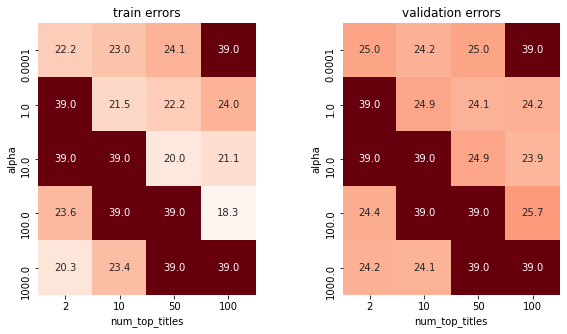

In [73]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=n_components_Tfidf)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=n_components_Tfidf)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('n_components'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('n_components'); plt.ylabel('alpha');

In [74]:
best_val_err

23.882748678519942

Cuối cùng là huấn luyện lại mô hình với các siêu tham số tốt nhất tìm được để ra được mô hình áp dụng cho tập kiểm tra.

### Áp dụng mô hình tốt nhất tìm được trên tập kiểm tra

In [ ]:
test_pred = full_pipeline.predict(test_)